https://habr.com/ru/companies/ruvds/articles/451872/

In [1]:
from time import sleep, strftime
from random import randint
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import smtplib
from email.mime.multipart import MIMEMultipart

In [2]:
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import re
import itertools
from datetime import date, timedelta

In [4]:
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager

# Этой командой открывается окно Chrome
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
sleep(2)

In [5]:
def load_more():
    try:
        more_results = "//button[@data-test-id='show-all-tickets-button']"
        driver.find_element(By.XPATH, more_results).click()
        sleep(randint(45,60))
    except:
        pass

In [6]:
def ticket_scrape(position):
    xp_ticket = "(//span[@class='s__wRhMOEwg2Ub7G1CotYcY'][@data-test-id='price'])[{}]".format(position)
    ticket_content = driver.find_element(By.XPATH, xp_ticket).text

    signs_dict = {'\u202f': '',
                  '\u2009': '',
                  '\u200a': ' ',
                  '₽': '',
                  '+': '',
                  'В пути: ': ''}

    for key, value in signs_dict.items():
        ticket_content = ticket_content.replace(key, value)
        
    return ticket_content.split('\n')


In [7]:
def airports_scrape(position):
    try:
        city = "(//div[@data-test-id='city-name'])[{}]".format(position)
        driver.find_element(By.XPATH, city).click()

        city_iata = "(//div[@data-test-id='iata'])[2]"
        iata = driver.find_element(By.XPATH, city_iata).text
        return iata
    except:
        pass


In [8]:
def start_aviasales(city_from, city_to, num_passengers, date_start, date_end=None):
    """City codes - it's the IATA codes!
    Date format -  DDMM"""
    
    if date_end:
        aviasales = ('https://www.aviasales.ru/search/' + city_from + date_start + city_to + date_end + num_passengers)
    else:
        aviasales = ('https://www.aviasales.ru/search/' + city_from + date_start + city_to + num_passengers)
    
    driver.get(aviasales)
    sleep(randint(12,18))
    
    ticket_content = ticket_scrape(1)

    if date_end:
        df = pd.DataFrame([[int(ticket_content[0]), city_from, city_to, num_passengers, '{}.{}'.format(str(date_start)[:2], str(date_start)[2:]), '{}.{}'.format(str(date_end)[:2], str(date_end)[2:])]],
                columns = ['price', 'city_from', 'city_to', 'num_passengers', 'date_start', 'date_end'])
    else:
        df = pd.DataFrame([[int(ticket_content[0]), city_from, city_to, num_passengers, '{}.{}'.format(str(date_start)[:2], str(date_start)[2:])]],
                columns = ['price', 'city_from', 'city_to', 'num_passengers', 'date_start'])        

    return df


In [9]:
def start_aviasales_to_country(positions, city_from, country, num_passengers, date_start, date_end=None):
    """City codes - it's the IATA codes!
    Date format -  DDMM"""

    cities = []

    for position in list(range(1, positions+1)):
        aviasales = ('https://www.aviasales.ru/?params=' + city_from + country + num_passengers)
        driver.get(aviasales)
        sleep(randint(2,4))
        
        iata = airports_scrape(position)
        sleep(randint(2,4))

        if iata != None:
            cities.append(iata)

    if len(cities) == 0:
       if date_end:
           df = pd.DataFrame([[1000000, city_from, country, num_passengers, '{}.{}'.format(str(date_start)[:2], str(date_start)[2:]), '{}.{}'.format(str(date_end)[:2], str(date_end)[2:])]],
                   columns = ['price', 'city_from', 'city_to', 'num_passengers', 'date_start', 'date_end'])
       else:
           df = pd.DataFrame([[1000000, city_from, country, num_passengers, '{}.{}'.format(str(date_start)[:2], str(date_start)[2:])]],
                   columns = ['price', 'city_from', 'city_to', 'num_passengers', 'date_start'])    

    elif len(cities) == 1:
        df = start_aviasales(city_from, cities[0], num_passengers, date_start)

    elif len(cities) > 1:
        df = start_aviasales(city_from, cities[0], num_passengers, date_start)
        for city in cities[1:]:
            df_fly = start_aviasales(city_from, city, num_passengers, date_start)
            df = pd.concat([df, df_fly])

    return df
        


In [10]:
def generate_dates(start_date, end_date):

    #days = [(CN1, LA, VN, KH, MM, CN2)
    #       for CN1 in list(range(1, 3))
    #       for LA in ([0]) + list(range(7, 11))
    #       for VN in ([0]) + list(range(7, 11))
    #       for KH in ([0]) + list(range(3, 6))
    #       for MM in ([0]) + list(range(7, 11))
    #       for CN2 in range(7, 11)]

    days = [(CN1, KH, MM, CN2)
           for CN1 in list(range(1, 3))
           for KH in ([0]) + list(range(3, 7))
           for MM in ([0]) + list(range(7, 12))
           for CN2 in range(7, 12)]

    best_days = []
    delta = re.findall(r'[\d]+', str(end_date - start_date))[0]

    for index, value in enumerate(days):
        if int(delta) - sum(days[index]) == 0:
            best_days.append(days[index])
    
    return best_days


In [11]:
def rewrite_dates(travel_dates):
    travel_dates_rewrited = []
    for key, value in travel_dates.items():
        date = '0' + str(value.day) + '0' + str(value.month)
        travel_dates_rewrited.append((key, date[-4:]))
    
    return travel_dates_rewrited

In [12]:
#df = start_aviasales('SHA', 'PEK', '1', '1904')
#df

In [13]:
#df = start_aviasales_to_country(1, 'SHA', 'LA', '1', '1904')
#df

In [14]:
start_point = 'PEK'
end_point = 'SHA'

start_date = date(2024, 4, 13)
end_date = date(2024, 5, 5)

best_days = generate_dates(start_date, end_date)
len(best_days)

29

In [15]:
#df = pd.DataFrame(columns=['final_price', 'price1', 'date1', 'city_from1', 'city_to1',
#                                          'price2', 'date2', 'city_from2', 'city_to2',
#                                          'price3', 'date3', 'city_from3', 'city_to3', 
#                                          'price4', 'date4', 'city_from4', 'city_to4'])
#
#for i in tqdm(range(len(best_days))):
#
#    travel_days = {}
#
#    if best_days[i][1] != 0:
#        travel_days["LA"] = best_days[i][1]
#
#    if best_days[i][2] != 0:
#        travel_days["VN"] = best_days[i][2]
#
#    if best_days[i][3] != 0:
#        travel_days["KH"] = best_days[i][3]
#
#    if best_days[i][4] != 0:
#        travel_days["MM"] = best_days[i][4]
#
#    print("Search:  PEK ({} days) + LA ({} days) + VN ({} days) + KH ({} days) + MM ({} days) + SHA ({} days)".format(best_days[i][0], best_days[i][1], best_days[i][2], 
#                                                                                                                      best_days[i][3], best_days[i][4], best_days[i][5]))
#
#    countries_perm = list(itertools.permutations(list(travel_days.keys())))
#
#    for order in countries_perm:
#        travel_dates = {start_point: start_date + timedelta(days=best_days[i][0])}
#        last_date = travel_dates[start_point]
#
#        for country in order:
#            last_date += timedelta(days=travel_days[country])
#            travel_dates[country] = last_date
#
#        travel_dates[end_point] = end_date - timedelta(days=best_days[i][5])
#        travel_dates_rewrited = rewrite_dates(travel_dates)
#        
#        df_optimal = pd.DataFrame(columns=['price', 'city_from', 'city_to', 'num_passengers', 'date_start']) # df_optimal.price.sum() собирать в датафрейм вместе с городами и датами
#        current_city = start_point
#
#        for index, fly in enumerate(travel_dates_rewrited[:-1]):
#            if travel_dates_rewrited[index+1][0] == end_point:
#                df_fly = start_aviasales(current_city, travel_dates_rewrited[index+1][0], '1', fly[1])
#            else:
#                df_fly = start_aviasales_to_country(1, current_city, travel_dates_rewrited[index+1][0], '1', fly[1])
#            df_optimal.loc[len(df_optimal.index)] = df_fly[df_fly.price == df_fly.price.min()].values.flatten().tolist()
#            current_city = df_fly[df_fly.price == df_fly.price.min()].values.flatten().tolist()[2]
#
#        print(' Price:  {}'.format(df_optimal.price.sum()))
#        
#        new_travel = [df_optimal.price.sum()] + [x for xs in [[list(df_optimal['price'])[i], list(df_optimal['date_start'])[i], 
#                                                               list(df_optimal['city_from'])[i], list(df_optimal['city_to'])[i]] 
#                                                               for i in range(len(df_optimal))] for x in xs]
#        
#        df.loc[len(df.index)] = pd.Series(new_travel, index=df.columns[:len(new_travel)])

In [16]:
df = pd.DataFrame(columns=['final_price', 'price1', 'date1', 'city_from1', 'city_to1',
                                          'price2', 'date2', 'city_from2', 'city_to2',
                                          'price3', 'date3', 'city_from3', 'city_to3', 
                                          'price4', 'date4', 'city_from4', 'city_to4'])

for i in tqdm(range(len(best_days))):

    travel_days = {}

    if best_days[i][1] != 0:
        travel_days["SAI"] = best_days[i][1]

    if best_days[i][2] != 0:
        travel_days["RGN"] = best_days[i][2]

    print("Search:  PEK ({} days) + KH ({} days) + MM ({} days) + SHA ({} days)".format(best_days[i][0], best_days[i][1], best_days[i][2], best_days[i][3]))

    cities_perm = list(itertools.permutations(list(travel_days.keys())))

    for order in cities_perm:
        travel_dates = {start_point: start_date + timedelta(days=best_days[i][0])}
        last_date = travel_dates[start_point]

        for city in order:
            last_date += timedelta(days=travel_days[city])
            travel_dates[city] = last_date

        travel_dates[end_point] = end_date - timedelta(days=best_days[i][3])
        travel_dates_rewrited = rewrite_dates(travel_dates)
        
        df_optimal = pd.DataFrame(columns=['price', 'city_from', 'city_to', 'num_passengers', 'date_start']) # df_optimal.price.sum() собирать в датафрейм вместе с городами и датами
        current_city = start_point

        for index, fly in enumerate(travel_dates_rewrited[:-1]):
            df_fly = start_aviasales(current_city, travel_dates_rewrited[index+1][0], '1', fly[1])
            df_optimal.loc[len(df_optimal.index)] = df_fly[df_fly.price == df_fly.price.min()].values.flatten().tolist()
            current_city = df_fly[df_fly.price == df_fly.price.min()].values.flatten().tolist()[2]

        print(' Price:  {}'.format(df_optimal.price.sum()))
        
        new_travel = [df_optimal.price.sum()] + [x for xs in [[list(df_optimal['price'])[i], list(df_optimal['date_start'])[i], 
                                                               list(df_optimal['city_from'])[i], list(df_optimal['city_to'])[i]] 
                                                               for i in range(len(df_optimal))] for x in xs]
        
        df.loc[len(df.index)] = pd.Series(new_travel, index=df.columns[:len(new_travel)])

  0%|          | 0/29 [00:00<?, ?it/s]

Search:  PEK (1 days) + KH (0 days) + MM (10 days) + SHA (11 days)
 Price:  43377
Search:  PEK (1 days) + KH (0 days) + MM (11 days) + SHA (10 days)
 Price:  42858
Search:  PEK (1 days) + KH (3 days) + MM (7 days) + SHA (11 days)
 Price:  57933
 Price:  55645
Search:  PEK (1 days) + KH (3 days) + MM (8 days) + SHA (10 days)
 Price:  57414
 Price:  56453
Search:  PEK (1 days) + KH (3 days) + MM (9 days) + SHA (9 days)
 Price:  57933
 Price:  55265
Search:  PEK (1 days) + KH (3 days) + MM (10 days) + SHA (8 days)
 Price:  58005
 Price:  57649
Search:  PEK (1 days) + KH (3 days) + MM (11 days) + SHA (7 days)
 Price:  57933
 Price:  55126
Search:  PEK (1 days) + KH (4 days) + MM (7 days) + SHA (10 days)
 Price:  57466
 Price:  56775
Search:  PEK (1 days) + KH (4 days) + MM (8 days) + SHA (9 days)
 Price:  57877
 Price:  55323
Search:  PEK (1 days) + KH (4 days) + MM (9 days) + SHA (8 days)
 Price:  57877
 Price:  57148
Search:  PEK (1 days) + KH (4 days) + MM (10 days) + SHA (7 days)
 Pric

In [17]:
df

,final_price,price1,date1,city_from1,city_to1,price2,date2,city_from2,city_to2,price3,date3,city_from3,city_to3,price4,date4,city_from4,city_to4
0,43377,23944,14.04,PEK,RGN,19433,24.04,RGN,SHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42858,23944,14.04,PEK,RGN,18914,25.04,RGN,SHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57933,21173,14.04,PEK,SAI,17327,17.04,SAI,RGN,19433,24.04,RGN,SHA,NaN,NaN,NaN,NaN
3,55645,23944,14.04,PEK,RGN,11981,21.04,RGN,SAI,19720,24.04,SAI,SHA,NaN,NaN,NaN,NaN
4,57414,21173,14.04,PEK,SAI,17327,17.04,SAI,RGN,18914,25.04,RGN,SHA,NaN,NaN,NaN,NaN
5,56453,23944,14.04,PEK,RGN,11659,22.04,RGN,SAI,20850,25.04,SAI,SHA,NaN,NaN,NaN,NaN
6,57933,21173,14.04,PEK,SAI,17327,17.04,SAI,RGN,19433,26.04,RGN,SHA,NaN,NaN,NaN,NaN
7,55265,23944,14.04,PEK,RGN,11601,23.04,RGN,SAI,19720,26.04,SAI,SHA,NaN,NaN,NaN,NaN
8,58005,21173,14.04,PEK,SAI,17399,17.04,SAI,RGN,19433,27.04,RGN,SHA,NaN,NaN,NaN,NaN
9,57649,23944,14.04,PEK,RGN,12102,24.04,RGN,SAI,21603,27.04,SAI,SHA,NaN,NaN,NaN,NaN


In [18]:
df = df.sort_values(by=['final_price'])
df.to_csv('pek-(mm-kh)-sha.csv', index=False)

In [19]:
df1 = pd.DataFrame()
df1['price'] = df['price1']
df1['travel'] = df['city_from1'] + '-' + df['city_to1']

df2 = pd.DataFrame()
df2['price'] = df['price2']
df2['travel'] = df['city_from2'] + '-' + df['city_to2']

df3 = pd.DataFrame()
df3['price'] = df['price3']
df3['travel'] = df['city_from3'] + '-' + df['city_to3']

df_all = pd.concat([df1, df2, df3], ignore_index=True)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'PEK-RGN'),
  Text(1, 0, 'PEK-SAI'),
  Text(2, 0, 'RGN-SHA'),
  Text(3, 0, 'RGN-SAI'),
  Text(4, 0, 'SAI-RGN'),
  Text(5, 0, 'SAI-SHA')])

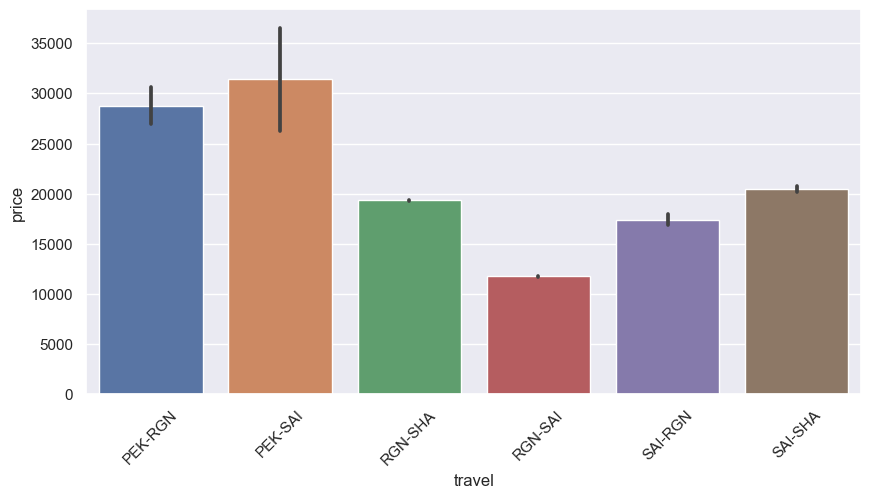

In [20]:
sns.set_theme(rc={'figure.figsize':(10,5)})
sns.barplot(df_all, x='travel', y='price')
plt.xticks(rotation=45)